In [1]:
# libraries
using Flux             # the julia ml library
using Images           # image processing and machine vision for julia
using MLJ              # make_blobs, rmse, ConfusionMatrix
using MLDataUtils      # label, nlabel, labelfreq
using MLDatasets       # mnist

using GLM              # lm, glm, predict

using LinearAlgebra    # pinv pseudo-inverse matrix
using Metrics          # r2-score
using Random
using StatsBase        # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

using CSV
using DataFrames


In [2]:
# functions library

RMSE(ŷ, y) = mean(abs.(ŷ - y))


RMSE (generic function with 1 method)

In [3]:
function matrix2vector(M)
    d = length(M)
    v = reshape(M, (d,))   # columns are organized left-to-right as single vector
end


matrix2vector (generic function with 1 method)

In [4]:
function imageSet2rowMatrix(imageSet)
    # converts an image set (rows x columns x N) 3D-array on a (vector x N) 2D-array
    # each row of the matrix corresponds to one image

    N = size(imageSet)[3]
    d = size(imageSet)[1] * size(imageSet)[2]

    X = [ matrix2vector(imageSet[:, :, i]) for i in 1:N ]
    X = DataFrame(X, :auto) |> Matrix
    X = X' |> Matrix
    return X
end

imageSet2rowMatrix (generic function with 1 method)

In [5]:
function categoryStratificationChart(trainY, testY)
    # using MLDataUtils
    
    # check for unique labels
    l = label(trainY); sort!(l)
    N = nlabel(trainY)

    # trainset classes
    d1 = labelfreq(trainY)
    d1 = DataFrame([(k, v) for (k,v) in d1])
    rename!(d1, ["class","trainset"])

    # testset classes
    d2 = labelfreq(testY)
    d2 = DataFrame([(k, v) for (k,v) in d2])
    rename!(d2, ["class","testset"])

    # make a single df (df facilitates sorting)
    df = leftjoin(d1, d2, on = :class)
    sort!(df,[:class])

    # make a matrix out of df (matrix facilitates plotting)
    M = df |> Array
    p1 = groupedbar(M[:, 2:3],
        bar_position = :dodge,
        size=(500,300),
        xtick=(1:N, l),   # não é obvio chegar a esta configuração
        legend=:outerright,
        label=["trainset" "testset"])
    p1 = title!("Dataset stratification", xlabel="categories", ylabel="count")
end


categoryStratificationChart (generic function with 1 method)

In [6]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();
length(trainY_original), length(validationY_original)

(60000, 10000)

,,,,

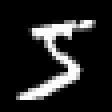
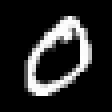
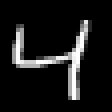
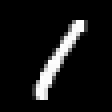
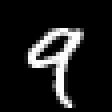

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [7]:
display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [ ]:
# distribution of labels
categoryStratificationChart(trainY_original, validationY_original)

In [ ]:
#(trX, trY), (vX, vY) = splitobs((trainX, trainY), at = 0.7);
(trX, trY), (teX, teY) = stratifiedobs((trainX_original, trainY_original), p = 0.7); ### proporção aqui é "p", em splitjobs é "at"
categoryStratificationChart(trY, teY)

#### Linear regression

In [ ]:
# dataset to X,y arrays

trainX = imageSet2rowMatrix(trX)
testX  = imageSet2rowMatrix(teX)
validationX = imageSet2rowMatrix(validationX_original)

trainY = copy(trY)
testY  = copy(teY)
validationY = copy(validationY_original);

In [ ]:
# fit the model
using CategoricalArrays
ycat = CategoricalArrays(trainY)
lmFit = lm(Float64.(trainX), ycat)   # converter X para Float64

# predict with trainset (no need to declare it)
y_hat = GLM.predict(lmFit);


In [ ]:
# metrics
display(MLJ.rmse(y_hat, trainY))

### MLJ.ConfusionMatrix(y_hat, trainY)

In [ ]:
?ConfusionMatrix